In [1]:
import IPython
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random, math
%matplotlib inline

import gym, gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 145) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://people.inf.elte.hu/lorincz/Files/RL_2006/SuttonBook.pdf
    
    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward 
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [2]:
#Let's look at the environment 
env.render()
print("We start from x, and we want to reach the goal T, the cliff is denoted by C")
n_actions = env.action_space.n
print("Action space = " + str(n_actions))

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T

We start from x, and we want to reach the goal T, the cliff is denoted by C
Action space = 4


In [3]:
#We define our Q-learning agent
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
               
        self.get_legal_actions = get_legal_actions
        """Creates a dictionary for states containing a dictionary for actions containing Q-value"""
        self.qvalues = defaultdict(lambda: defaultdict(lambda: 0))           
        self.alpha    = alpha     # Learning rate
        self.epsilon  = epsilon   # Exploration probability
        self.discount = discount  # Gamma

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self.qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self.qvalues[state][action] = value

    def get_value(self, state):
        """ Computes V(s) using current q-values """
        possible_actions = self.get_legal_actions(state)
        
        if len(possible_actions) == 0: return 0.0   #If there are no legal actions
        return max([self.get_qvalue(state,action) for action in possible_actions])

    def update(self, state, action, reward, next_state):
        """ Using temporal difference update  """

        gamma = self.discount
        learning_rate = self.alpha

        qvalue_target = reward+gamma*self.get_value(next_state)
        qvalue = learning_rate*qvalue_target+(1-learning_rate)*self.get_qvalue(state,action)
        
        self.set_qvalue(state, action, qvalue)
   
    def get_best_action(self, state):
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        action_value_dict = {action: self.get_qvalue(state, action) for action in possible_actions}
        best_action = sorted(action_value_dict, key=lambda x:action_value_dict[x], reverse=True)[0]
        return best_action

    def get_action(self, state):
        """ Using epsilon greedy policy """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
  
        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon
        prob = random.random()
        
        if prob<=epsilon:
            chosen_action = np.random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)
        
        return chosen_action

In [4]:
class EVSarsaAgent(QLearningAgent): # It is almost the same implementation of Q-Learning

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}
                  
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        if len(possible_actions) == 0: return 0.0 # If there are no legal actions
        
        state_value = 0
        for action in possible_actions:
            if action == self.get_best_action(state):
                state_value += ((1-epsilon)+epsilon/len(possible_actions))*self.get_qvalue(state,action)
            else:
                state_value += epsilon/len(possible_actions)*self.get_qvalue(state,action)
        
        return state_value

In [5]:
def play_and_train(env,agent,t_max=10**4):

    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.get_action(s)
        
        next_s,r,done,_ = env.step(a)
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward

In [6]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

EVSARSA mean reward = -29.41
QLEARNING mean reward = -74.72


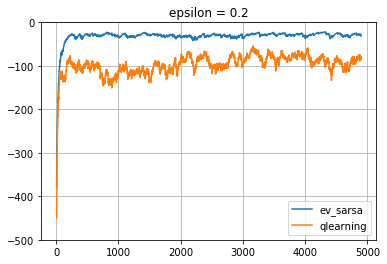

In [7]:
#This visualization code has been taken from the coursera notebook
from IPython.display import clear_output
from pandas import ewma, Series
moving_average = lambda ts, span=100: ewma(Series(ts), min_periods=span//10, span=span).values

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    #Note: agent.epsilon stays constant
    
    if i %100 ==0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [8]:
#This visualization code has been taken from the coursera notebook
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape
    
    actions = '^>v<'
    
    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " % actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [9]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  >  v  >  v  >  v  v  >  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
